In [1]:
import sys
sys.path.append('../..')

import pandas as pd
import xarray as xr

import panel as pn
import panel.widgets as pnw
from panel.interact import interact
pn.extension()

import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas

greens = matplotlib.cm.get_cmap('Greens')
reds = matplotlib.cm.get_cmap('Reds')
blues = matplotlib.cm.get_cmap('Blues')

from agrifoodpy.population.population_data import UN
from agrifoodpy.food.food_supply import FAOSTAT, scale_food, plot_food
from agrifoodpy.impact.impact import PN18
from agrifoodpy.impact import impact

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# area = 10 #Australia
area_pop = 826 #UK
area_fao = 229 #UK

# Select a year from the 1961-2019 range
year = 2019

In [3]:
population = UN.Medium.sel(Region=area_pop, Year=year)*1000

In [4]:
matching = pd.read_csv("PN18 and FAOSTAT list matching matrix.csv", sep=":")

alternative = matching["Alternative"]
alt_mask = ~np.isnan(alternative)

matching.drop("Alternative", axis=1, inplace=True)
matching.fillna(0, inplace=True)

# MAtching should only take one impact xarray variable as input
# issue a warning when more than one? 
# Take "alternative" as input too
# filling NaN should be made at the function level?
food_impact = impact.match(PN18, matching)
food_impact["GHG Emissions"].values[alt_mask] = alternative[alt_mask]
co2e_g = food_impact["GHG Emissions"]/1000

In [5]:
elements_dict = {'production':0,
            'imports':1,
            'exports':2,
            'stock':3,
            'feed':4,
            'seed':5,
            'losses':6,
            'processing':7,
            'other':8,
            'food':9,}

food_items = food_impact.Item.values
food_uk = FAOSTAT.sel(Region=area_fao, Item=food_items, Year=year)

kcal_day = food_uk["kcal"]
prot_day = food_uk["protein"]
fats_day = food_uk["fat"]

food_uk[list(elements_dict.keys())] = food_uk[list(elements_dict.keys())]*1e9/population/365.25
food_uk = food_uk[list(elements_dict.keys())]

In [6]:
Cereals = np.array([2511, 2513, 2514, 2515, 2516, 2517, 2518, 2520, 2531, 2532, 2533, 2534, 2535, 2807])
Pulses = np.array([2546, 2547, 2549, 2555])
Sugar = np.array([2536, 2537, 2541, 2542, 2543, 2558, 2562, 2570, 2571, 2572, 2573, 2574, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2586, 2745])
NutsSeed = np.array([2551, 2552, 2557, 2560, 2561])
VegetablesFruits = np.array([2563, 2601, 2602, 2605, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2625, 2641, 2775])
RuminantMeat =np.array([2731, 2732])
OtherMeat = np.array([2733, 2734, 2735, 2736])
Egg = np.array([2949])
Dairy = np.array([2740, 2743, 2948])
FishSeafood = np.array([2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769])
Other = np.array([2630, 2633, 2635, 2640, 2642, 2645, 2655, 2656, 2657, 2658, 2680, 2737])
NonFood = np.array([2559, 2575, 2659, 2781, 2782])

groups = np.array([Cereals, Pulses, Sugar,
          NutsSeed, VegetablesFruits, RuminantMeat,
          OtherMeat, Egg, Dairy,
          FishSeafood, Other, NonFood], dtype=object)

In [7]:
# Food groups are classified into plant and animal origin

plant_mask = np.arange(5)
animal_mask = np.arange(5, 10)
other_mask = np.arange(10, 12)

green_colors = greens(1/(2+plant_mask))
red_colors = reds(1/(2+animal_mask-5))
blue_colors = blues([0.5,1])

colors = np.concatenate((green_colors, red_colors, blue_colors))

In [8]:
kcal_g = kcal_day / food_uk["food"]
prot_g = prot_day / food_uk["food"]
fats_g = fats_day / food_uk["food"]

kcal_day_food_uk = food_uk[elements_dict.keys()] * kcal_g
prot_day_food_uk = food_uk[elements_dict.keys()] * prot_g
fats_day_food_uk = food_uk[elements_dict.keys()] * fats_g
co2e_day_food_uk = food_uk[elements_dict.keys()] * co2e_g

kcal_day_food_uk = kcal_day_food_uk.where(np.isfinite(kcal_day_food_uk), other=0)
prot_day_food_uk = prot_day_food_uk.where(np.isfinite(prot_day_food_uk), other=0)
fats_day_food_uk = fats_day_food_uk.where(np.isfinite(fats_day_food_uk), other=0)
co2e_day_food_uk = co2e_day_food_uk.where(np.isfinite(co2e_day_food_uk), other=0)
# food_uk = food_uk.where(np.isfinite(food_uk), other=0)


In [9]:
origin = "imports"
fallback = "exports"
items = np.concatenate(groups[plant_mask])
food = kcal_day_food_uk

In [10]:
plant_scaling  = pnw.FloatSlider(name='Plant scaling', value=1.0, start=0.5, end=2.5, step=0.1)

@pn.depends(plant_scaling)
def comp_map(plant_scaling):
    out = scale_food(food=food, scale=plant_scaling, origin=origin, items=items, constant=True, fallback=fallback)
    fig, _ = plot_food([food, out], items=groups, colors=colors, sharex=True)
    return fig

Column
    [0] ParamFunction(function)
    [1] FloatSlider(end=2.5, name='Plant scaling', start=0.5, value=1.0)
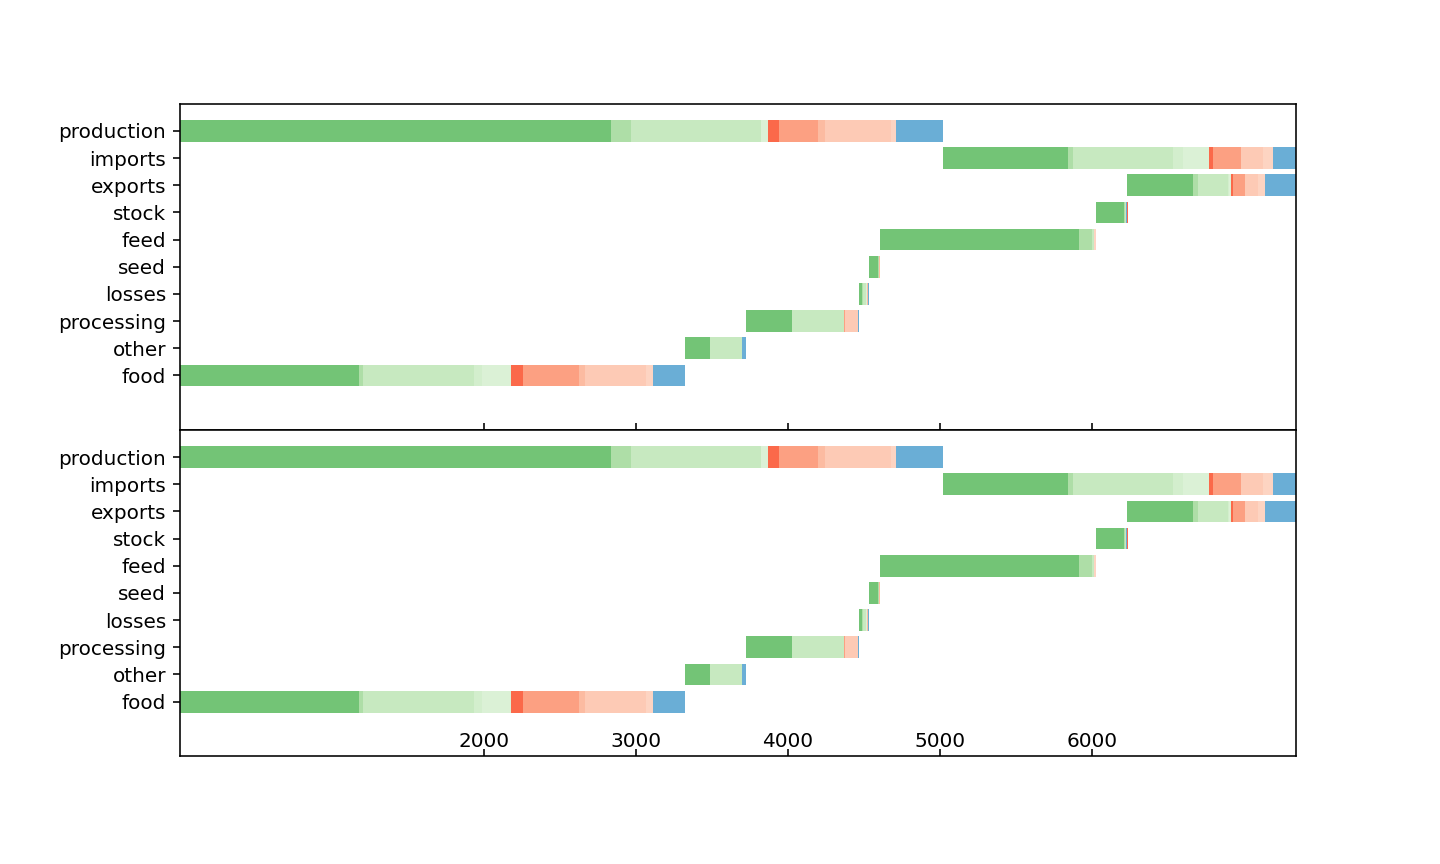

In [11]:
occupancy = pn.Column(comp_map, plant_scaling);
occupancy.servable()

In [12]:
%%time

import collections
import warnings
import copy

def test(food, items=None, colors=None, sharex=False):

    # Check if a list of food xarrays was provided. If single one, convert to list
    to_plot = food
    if not isinstance(food, collections.abc.Iterable):
        to_plot = (food, )

    fig, axs = plt.subplots(len(to_plot), figsize=(10,3*len(to_plot)), sharex=sharex)
    plt.subplots_adjust(hspace=0)

    for ax, unit in zip(axs, to_plot):

        # If not list of items is provided, plot all the items
        if items is None:
            items = unit.Item.values

        # If colors are not defined, generate a list from the standard cycling
        if colors is None:
            colors = [f"C{ic}" for ic in range(len(items))]

        elements = list(unit.keys())

        # Plot the production and imports first
        cumul = 0
        for ie, element in enumerate(elements[:2]):
            for ii, item in enumerate(items):
                val = np.sum(unit[element].sel(Item=item))
                ax.barh(ie, left = cumul, width=val, color=colors[ii])
                cumul += val

        subs = copy.deepcopy(elements)
        subs.remove("imports")
        subs.remove("production")

        # Then the rest of items
        cumul = 0
        for ie, element in enumerate(reversed(subs)):
            for ii, item in enumerate(items):
                val = np.sum(unit[element].sel(Item=item))
                ax.barh(9-ie, left = cumul, width=val, color=colors[ii])
                cumul += val

        ax.set_yticks(np.arange(len(elements)))
        ax.set_xticks(ax.get_xticks()[1:-1])
        ax.tick_params(axis="x",direction="in", pad=-12)
        ax.set_yticklabels(labels=elements)
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_ylim(len(elements)+1,-1)
        ax.set_xlim(0,8000)

    return fig, axs

out = scale_food(food=food, scale=1.3, origin=origin, items=items, constant=True, fallback=fallback)
test([food, out], items=groups, colors=colors, sharex=True)
plt.show()

CPU times: user 534 ms, sys: 3.89 ms, total: 538 ms
Wall time: 539 ms


/home/juancordero/Software/anaconda3/envs/fair/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
